##### Imports

In [ ]:
# Installing and checking keras tuner and tensorflow
!pip install -q --upgrade tensorflow
!pip install keras-tuner -q --upgrade

     |████████████████████████████████| 462 kB 5.5 MB/s 
     |████████████████████████████████| 133 kB 3.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# #Verify Pytorch installation
# import torch
# print(torch.__version__)

In [ ]:
# Verify Tensorflow  installation
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
#Necessary Library Imports 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt
from tensorflow import keras
import math 
import numpy as np
import os
from sklearn.dummy import DummyClassifier
import pandas as pd
import time
import pickle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import WhitespaceTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.metrics import roc_auc_score
import csv
import gzip
import urllib.request
import requests
import nltk
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input
from keras.layers import LSTM
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import Model

In [ ]:
!wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2022-03-25 15:21:41--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  41.9MB/s    in 30s     

2022-03-25 15:22:12 (42.4 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
# idx = 0
# vocab = {}
# # Save embeddings to numpy array (vocab_size x dimensions)
# # We manually add 2 special tokens (for padding & unknown words)
# with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
#     for l in f:
#         line = l.rstrip().split(' ')
#         if idx == 0:
#             vocab_size = int(line[0]) + 2
#             dim = int(line[1])
#             vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
#             vocab["__PADDING__"] = 0
#             vocab["__UNK__"] = 1
#             idx = 2
#         else:
#             vocab[line[0]] = idx
#             emb = np.array(line[1:]).astype(np.float)
#             if (emb.shape[0] == dim):
#                 vecs[idx,:] = emb  # Embeddings are saved in an numpy array vecs
#                 idx+=1
#             else:
#                 continue

#     # Serialize vocab & embeddings
#     pickle.dump(vocab,open("/content/gdrive/My Drive/fasttext_voc.pkl" ,'wb'))
#     np.save("/content/gdrive/My Drive/fasttext.npy",vecs)
    
#     # Free ram
#     vecs = None
#     vocab = None
#     emb = None  

In [ ]:
fasttext_embed = np.load("/content/gdrive/My Drive/fasttext.npy")
fasttext_word_to_index = pickle.load(open("/content/gdrive/My Drive/fasttext_voc.pkl", 'rb')) 

In [ ]:
#Downloading Stopwords & Dictionary
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)

#Downloading data(In compressed form) provided by Stanford University
!wget -q  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

#Unzipping data
!tar  xzf aclImdb_v1.tar.gz

In [ ]:
#Setting random seed so we can analyse results
np.random.seed(365)

##### Loading Data

In [ ]:
#Initializing Function to load data
def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
          #Renaming sentiment to values 
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])
    #Shuffling train data
    np.random.shuffle(data["train"])        
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
     #Shuffling test data
    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])
    return data["train"], data["test"] 

In [ ]:
# Loading the data into train,test
train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

In [ ]:
#Combining them together
newdf=pd.concat([train_data,test_data],ignore_index=True)
newdf=newdf[0:1000]
newdf.sentiment.sum()

495

##### Preprocessing + Learning Curves Function

In [ ]:
#Splitting our dataset into train & test
X_train,X_val = train_test_split(newdf,train_size=0.7,random_state=1)

#Splitting our test set into dev & test 
X_dev,X_test= train_test_split(X_val, test_size =  0.6 ,random_state=1)

#Checking lengths
print('Train length',X_train.shape[0])
print('Dev length',X_dev.shape[0])
print('Test length',X_test.shape[0])

Train length 700
Dev length 120
Test length 180


In [ ]:
#Average train document length
X_train['countWords'] = newdf.text.str.count(' ') + 1
average=X_train.countWords.sum()/len(newdf)
print('We have an average of ',round(average),'words per review for the train set.')

We have an average of  167 words per review for the train set.


In [ ]:
MAX_SEQUENCE_LENGTH = max(X_train.countWords)
print('The max sequence length is :', MAX_SEQUENCE_LENGTH )

The max sequence length is : 1007


In [ ]:
#Init lemmatizer
lemmzer = WordNetLemmatizer() 

In [ ]:
#Preprocessing Function
def prep(corpus): # fun to preprocess the corpus # allagi 
  corpus= corpus.apply(lambda x:x.lower()) #Lowercase
  corpus= corpus.apply(lambda x:re.sub(r'<.*?>', ' ', x)) #Remove html tags
  corpus= corpus.apply(lambda x: re.sub(r'\W', ' ', str(x))) #Remove punctuation
  corpus= corpus.apply(lambda x:re.sub('\d+', ' ', x)) #Remove numbers
  corpus= corpus.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) #Remove single characters
  corpus= corpus.apply(lambda x:re.sub(r'\s+', ' ',x)) #Remove multiple spaces
  corpus= corpus.apply(lambda x:[lemmzer.lemmatize(word) for word in x.split()]) #Running Lemmatizer by splitting the sentences into words
  corpus= corpus.apply(lambda x:' '.join(x)) #Re-forming the previously split sentences
  return corpus

In [ ]:
#Running prep on our dataset
X_train.text=prep(X_train.text)
X_dev.text=prep(X_dev.text)
X_test.text = prep(X_test.text)

#Renaming our target values
y_train = X_train.sentiment
y_dev = X_dev.sentiment
y_test = X_test.sentiment

In [ ]:
#Dataframe with train and dev data for our Grid Search
param=pd.concat([X_train,X_dev],axis=0)
y_param=param.sentiment

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser","ner"])
nlp.add_pipe(nlp.create_pipe('sentencizer')) 

def tokenize_samples(samples):
  
  tokenized_samples = []
  for i in samples.index:
    doc = nlp(samples[i])  # Tokenize the sample into sentences
    tokens = []
    for sent in doc.sents:
      for tok in sent:  # Iterate through the words of the sentence
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
          continue
        if tok.text.strip():  
          tokens.append(tok.text.replace('"',"'").strip())
    tokenized_samples.append(tokens)

  return tokenized_samples

X_train_tokenized = tokenize_samples(X_train.text)
X_dev_tokenized = tokenize_samples(X_dev.text)
X_test_tokenized = tokenize_samples(X_test.text)
param_tokenized=tokenize_samples(param.text) 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 500 
MAX_SEQUENCE_LENGTH = 50 
EMBEDDING_DIM = fasttext_embed.shape[1]

# Init tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='__UNK__')
# num_words: the maximum number of words to keep, based on word frequency.
# oov_token: will be used to replace OOV WORDS

# Fit tokenizer (Updates internal vocabulary based on a list of texts.)
tokenizer.fit_on_texts([" ".join(x) for x in X_train_tokenized])

# Converts text to sequences of IDs
train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_train_tokenized])
dev_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_dev_tokenized])
param_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in param_tokenized])



train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
dev_data = pad_sequences(dev_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

param_data = pad_sequences(param_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post') 

In [ ]:
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_test_tokenized])
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post') 

In [ ]:
# from sklearn.decomposition import PCA, TruncatedSVD

# # Dimensionality Reduction using SVD
# svd = TruncatedSVD(n_components=250, random_state=4321)
# x_train_trunc = svd.fit_transform(train_data)
# x_dev_trunc = svd.fit_transform(dev_data)
# x_param_trunc = svd.fit_transform(param_data)
# x_test_trunc = svd.fit_transform(test_data)

In [ ]:
word_index = tokenizer.word_index
print('Found {} unique tokens.\n'.format(len(word_index)))

print(word_index) 

Found 13111 unique tokens.

{'__UNK__': 1, 'movie': 2, 'wa': 3, 'film': 4, 'like': 5, 'ha': 6, 'time': 7, 'good': 8, 'character': 9, 'story': 10, 'scene': 11, 'great': 12, 'life': 13, 'bad': 14, 'people': 15, 'way': 16, 'don': 17, 'think': 18, 'thing': 19, 'love': 20, 'watch': 21, 'acting': 22, 'know': 23, 'actor': 24, 'little': 25, 'look': 26, 'seen': 27, 'end': 28, 'best': 29, 'doe': 30, 'plot': 31, 'work': 32, 'better': 33, 'm': 34, 'man': 35, 'lot': 36, 'find': 37, 'year': 38, 'come': 39, 'role': 40, 'watching': 41, 'director': 42, 'want': 43, 'real': 44, 've': 45, 'new': 46, 'performance': 47, 'guy': 48, 'going': 49, 'got': 50, 'didn': 51, 'funny': 52, 'woman': 53, 'isn': 54, 'doesn': 55, 'u': 56, 'play': 57, 'fan': 58, 'world': 59, 'feel': 60, 'right': 61, 'cast': 62, 'thought': 63, 'star': 64, 'old': 65, 'girl': 66, 'actually': 67, 'action': 68, 'pretty': 69, 'point': 70, 'child': 71, 'day': 72, 'big': 73, 'fact': 74, 'minute': 75, 'try': 76, 'set': 77, 'friend': 78, 'moment': 7

In [ ]:
# Previously, we saved all fasttext embeddings to a NumPy array for quick access
# Now, we save the fasttext embeddings for the words that we only need, based on the tokenizer

embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))  # +2 (pad, unkown)

for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

print(embedding_matrix)

[[ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [-0.0058  0.0974  0.0105 ...  0.1226 -0.0888 -0.1918]
 ...
 [-0.0305 -0.0284 -0.0198 ...  0.077   0.0079  0.0555]
 [-0.0394 -0.0197 -0.0269 ...  0.0852  0.0593 -0.0074]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]


In [ ]:
# make lists to arrays
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test) 

In [ ]:
#Runs in approx 5 minutes

from gensim.models import KeyedVectors

fasttext = KeyedVectors.load_word2vec_format('cc.en.300.vec')

In [ ]:
#Calculate centroid function

import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS


def text_centroid(text, model):
    
    text_vec =[]
    counter = 0
    for word in text:
        if word in STOP_WORDS:
          continue         
        try:
            if counter == 0:
                text_vec = model[word.lower()]
            else:
                text_vec = np.add(text_vec, model[word.lower()])
            counter+=1
        except:
            pass
    
    return np.asarray(text_vec) / counter
 

In [ ]:
X_train_centroids = []
for sentence in X_train_tokenized:
    X_train_centroids.append(text_centroid(sentence,fasttext))   
X_train_centroids = np.stack(X_train_centroids, axis=0)

X_dev_centroids = []
for sentence in X_dev_tokenized:
    X_dev_centroids.append(text_centroid(sentence,fasttext))   
X_dev_centroids = np.stack(X_dev_centroids, axis=0)

X_test_centroids = []
for sentence in X_test_tokenized:
    X_test_centroids.append(text_centroid(sentence,fasttext))   
X_test_centroids = np.stack(X_test_centroids, axis=0)

X_param_centroids = []
for sentence in param_tokenized:
    X_param_centroids.append(text_centroid(sentence,fasttext))   
X_param_centroids = np.stack(X_param_centroids, axis=0) 

In [ ]:
# #Init TFIDF
# vectorizer = TfidfVectorizer(
#     ngram_range = (1, 2), 
#     max_features = 7500,
#     sublinear_tf = True, 
#     stop_words = stopwords.words('english'))

In [ ]:
# #Vocabulary Size
# VocabSize = TfidfVectorizer( 
#     sublinear_tf = True, 
#     stop_words = stopwords.words('english'))
# vocabsize = VocabSize.fit_transform(train_data.text)
# print("Train dataset's vocabulary size is",vocabsize.shape[1],"words long.")

In [ ]:
# #Transforming all text datasets
# x_train_tfidf = vectorizer.fit_transform(train_data.text)
# x_test_tfidf = vectorizer.transform(test_data.text)
# x_dev_tfidf = vectorizer.transform(dev_data.text)
# x_param_tfidf=vectorizer.transform(param.text)

# # get_feauture_names() for a more thorough view
# print(vectorizer.get_feature_names()) 

In [ ]:
# print('Shape of training data: {}\n'.format(x_train_tfidf.shape))
# print('Shape of test data: {}\n'.format(x_test_tfidf.shape))
# print('Shape of dev data: {}\n'.format(x_dev_tfidf.shape))
# print('Shape of param data: {}\n'.format(x_param_tfidf.shape))

# #print(x_test_tfidf[0, :])  # Sparce matrix --> Saves only the cells which are not zero

In [ ]:
# # Number of features to keep
# k = 2500 # we tested for k= (500,1000,1500,2000,2500,3000,3750) with 1/3 of the total features we managed to get the same scores +- 1%

# # Convert sparse matrix to np.array --> Slow
# x_train_tfidf_array = x_train_tfidf.toarray()  

# # The function relies on nonparametric methods 
# # based on entropy estimation from k-nearest neighbors distances
# mutual_information = mutual_info_classif(x_train_tfidf_array,train_data.sentiment, n_neighbors=5, 
#                                          discrete_features=True,
#                                          random_state=4321)

# # Indexes of the feature columns
# indexes = np.arange(len(mutual_information))

# # Sort by mutual information values --> (value, idx)
# sorted_indexes = sorted(zip(mutual_information, indexes), reverse=True)
# print('Sorted indexes: {}'.format(sorted_indexes[:4]))

# # keep the indexes of the best k features
# best_idxs = [idx for val, idx in sorted_indexes[:k]]
# print('Best indexes: {}\n'.format(best_idxs[:4]))

# # Keep only the colums of the best features
# x_train_best_tfidf = x_train_tfidf_array[:, best_idxs]
# x_test_best_tfidf = x_test_tfidf[:, best_idxs]
# x_dev_best_tfidf = x_dev_tfidf[:, best_idxs]
# print('Shape of training data: {} --> {}'.format(x_train_tfidf.shape, x_train_best_tfidf.shape))
# print('Shape of test data: {} --> {}\n'.format(x_test_tfidf.shape, x_test_best_tfidf.shape))

In [ ]:
# #Replacing tfidf with the one above(k best features)
# x_train_tfidf = x_train_best_tfidf
# x_test_tfidf = x_test_best_tfidf
# x_dev_tfidf = x_dev_best_tfidf

In [ ]:
#Learning Curves Init
def F1_Curves(function,title):
  #Split into 5 parts/Round numbers
  parts = np.linspace(0.20,1,5)*X_train_centroids.shape[0]
  #Init lists
  trainlist = []
  testlist = []
  devlist = []
  for p in parts:
    estimator = function
    #Fit with part of the data / Increases for every loop
    estimator.fit(X_train_centroids[:int(p)],y_train[:int(p)])
    #Saving scores
    trainlist.append(f1_score(y_train[:int(p)],estimator.predict(X_train_centroids[:int(p)]),average='macro'))
    testlist.append(f1_score(y_test,estimator.predict(X_test_centroids),average='macro'))
    devlist.append(f1_score(y_dev,estimator.predict(X_dev_centroids),average='macro'))
  #Plotting lines
  plt.plot(parts,trainlist,label='Train Score')
  plt.plot(parts,testlist,label='Test Score')
  plt.plot(parts,devlist,label='Dev Score')
  plt.xlabel('Training Examples')
  plt.ylabel('F1 Score')
  plt.legend(loc='lower right')
  plt.title('Learning Curves for '+title)
  plt.show()

In [ ]:
#Predefined Split
split_index =( [-1]*len(train_data))+([0]*len(dev_data))
pds = PredefinedSplit(test_fold = split_index)

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

##### Most frequent Classifier (1st Baseline)

Training took: 0.0023779869079589844 seconds 

Train accuracy: 50.00% 

Dev accuracy: 51.67% 

Test accuracy: 51.67% 

#Class 0 in Train dataset: (350,)
#Class 1 in Train dataset: (350,)

Confusion Matrix for test data:


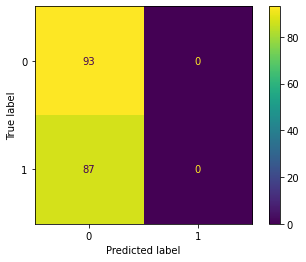

In [ ]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(X_train_centroids, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate on train,dev, and test subsets
predictions_train = baseline.predict(X_train_centroids)
score = accuracy_score(y_train, predictions_train)
print("Train accuracy: {:.2f}% \n".format(score*100))

predictions_dev = baseline.predict(X_dev_centroids)
score = accuracy_score(y_dev, predictions_dev)
print("Dev accuracy: {:.2f}% \n".format(score*100))

predictions_test = baseline.predict(X_test_centroids)
score = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))

print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape)

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=baseline, X=X_test_centroids, y_true=y_test, values_format = '.0f');

In [ ]:
#Classification Report on train,dev,test datasets.

print('Dummy Classifier')
print('')
print('Train')
print(classification_report(y_train,predictions_train))
print('')
print('Dev')
print(classification_report(y_dev,predictions_dev))
print('')
print('Test')
print(classification_report(y_test,predictions_test))

Dummy Classifier

Train
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       350
           1       0.00      0.00      0.00       350

    accuracy                           0.50       700
   macro avg       0.25      0.50      0.33       700
weighted avg       0.25      0.50      0.33       700


Dev
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        62
           1       0.00      0.00      0.00        58

    accuracy                           0.52       120
   macro avg       0.26      0.50      0.34       120
weighted avg       0.27      0.52      0.35       120


Test
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        93
           1       0.00      0.00      0.00        87

    accuracy                           0.52       180
   macro avg       0.26      0.50      0.34       180
weighted avg       0.27      0.52      

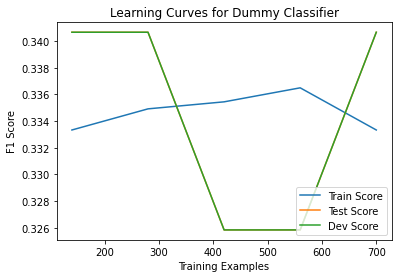

In [ ]:
F1_Curves(DummyClassifier(),'Dummy Classifier')

##### Logistic Regression (2nd Baseline)

In [ ]:
# Train // Approx 5 minutes
#Grid for Grid Search
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

clf = LogisticRegression(solver="saga")
clf_cv=GridSearchCV(clf,grid,cv=pds,scoring=f1)
start_time = time.time()
clf_cv.fit(X_param_centroids,y_param)
print("tuned hyperparameters :(best parameters) ",clf_cv.best_params_)
print("accuracy :",clf_cv.best_score_)
print("Training took: {} seconds \n".format(time.time() - start_time)) 

tuned hyperparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l1'}
accuracy : 0.7999999999999999
Training took: 4.415596961975098 seconds 



Train f1-score: 78.45%

Dev f1-score: 69.42% 

Test f1-score: 70.33%


Confusion Matrix for test data:


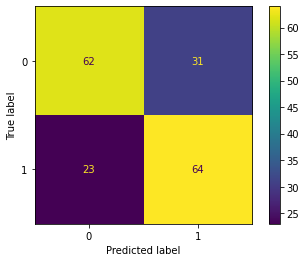

In [ ]:
# Train using the best parameters from Grid Search
clf = LogisticRegression()
clf.fit(X_train_centroids, y_train)

#  Evaluate on train,dev, and test subsets 
predictions_train = clf.predict(X_train_centroids)
predictions_proba_train=clf.predict_proba(X_train_centroids)
score = f1_score(y_train,predictions_train)
print("Train f1-score: {:.2f}%\n".format(score*100))

predictions_dev = clf.predict(X_dev_centroids)
predictions_proba_dev=clf.predict_proba(X_dev_centroids)
score = f1_score(y_dev, predictions_dev)
print("Dev f1-score: {:.2f}% \n".format(score*100))

predictions_test = clf.predict(X_test_centroids)
predictions_proba_test=clf.predict_proba(X_test_centroids)
score = f1_score(y_test,predictions_test)
print("Test f1-score: {:.2f}%\n".format(score*100))

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=X_test_centroids, y_true=y_test, values_format = '.0f');

In [ ]:
# #Classification Report on train,dev,test datasets.

print('Logistic Regression')
print('')
print('Train')
print(classification_report(y_train,predictions_train))
print('')
print('Dev')
print(classification_report(y_dev,predictions_dev))
print('')
print('Test')
print(classification_report(y_test,predictions_test))

Logistic Regression

Train
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       350
           1       0.76      0.81      0.78       350

    accuracy                           0.78       700
   macro avg       0.78      0.78      0.78       700
weighted avg       0.78      0.78      0.78       700


Dev
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        62
           1       0.67      0.72      0.69        58

    accuracy                           0.69       120
   macro avg       0.69      0.69      0.69       120
weighted avg       0.69      0.69      0.69       120


Test
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        93
           1       0.67      0.74      0.70        87

    accuracy                           0.70       180
   macro avg       0.70      0.70      0.70       180
weighted avg       0.70      0.70   

In [ ]:
#Setting up seaborne pallete
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)

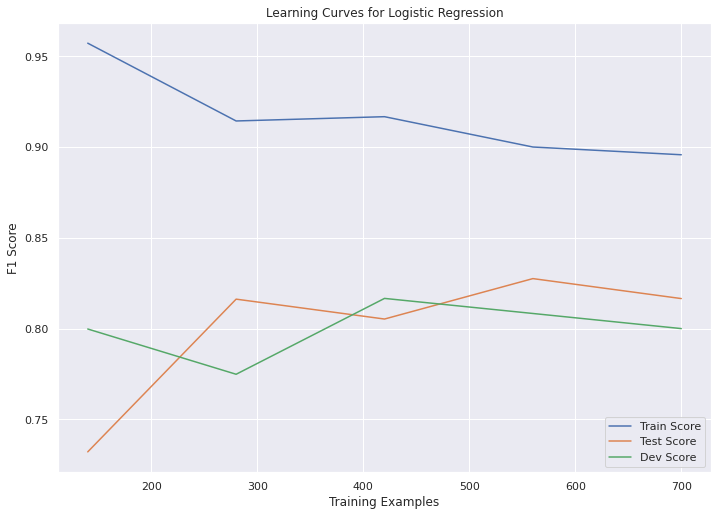

In [ ]:
F1_Curves(LogisticRegression(C=clf_cv.best_params_['C'],penalty=clf_cv.best_params_['penalty'], solver='saga'),"Logistic Regression")

In [ ]:
from sklearn.metrics import precision_recall_curve


#Training AUC for the 2 Classes
p,r,t = precision_recall_curve(y_train,predictions_proba_train[:,1])
positive_area=auc(r,p)
print(positive_area)

p2,r2,t2 = precision_recall_curve(1-y_train,predictions_proba_train[:,0])
negative_area=auc(r2,p2)
print(negative_area)

#Dev AUC for the 2 Classes
p3,r3,t3 = precision_recall_curve(y_dev,predictions_proba_dev[:,1])
positive_area2=auc(r3,p3)
print(positive_area2)

p4,r4,t4 = precision_recall_curve(1-y_dev,predictions_proba_dev[:,0])
negative_area2=auc(r4,p4)
print(negative_area2)


#Test AUC for the 2 Classes
p5,r5,t5 = precision_recall_curve(y_test,predictions_proba_test[:,1])
positive_area3=auc(r5,p5)
print(positive_area3)

p6,r6,t6 = precision_recall_curve(1-y_test,predictions_proba_test[:,0])
negative_area3=auc(r6,p6)
print(negative_area3)

0.8251495996015019
0.8434290730131861
0.6789233860379345
0.7544816782219214
0.7315830063277671
0.7348789291786784


##### Neural Network (3rd Baseline)

In [ ]:
#Initializing early-stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) 

In [ ]:
# def build_model(hp):
#     """
#     Builds model and sets up hyperparameter space to search.
    
#     Parameters
#     ----------
#     hp : HyperParameter object
#         Configures hyperparameters to tune.
        
#     Returns
#     -------
#     model : keras model
#         Compiled model with hyperparameters to tune.
#     """
#     # Initialize sequential API and start building model.
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(2500,)))
    
#     # Tune the number of hidden layers and units in each.
#     # Number of hidden layers: 1 - 3
#     # Number of Units: 32 - 512 with stepsize of 32
#     for i in range(1, hp.Int("num_layers", 1, 3)):
#         model.add(
#             keras.layers.Dense(
#                 units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
#                 activation="relu")
#             )
        
#         # Tune dropout layer with values from 0 - 0.5 with stepsize of 0.1.
#         model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0.1, 0.5, step=0.1)))
    
#     # Add output layer.
#     model.add(keras.layers.Dense(units=1, activation="sigmoid"))
    
#     # Tune learning rate for Adam optimizer with values from  0.001, or 0.0001/We run the loop for bigger learning rate values but it was too time consuming
#     #and we only kept the 2 best learning values for further development of our model.
#     hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4])
    
#     # Define optimizer, loss, and metrics
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss=keras.losses.BinaryCrossentropy(),
#                   metrics=["accuracy"])
    
#     return model

In [ ]:
# # Instantiate the tuner
# #The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model
# tuner = kt.Hyperband(build_model,
#                      #Metric which will be used for the hyperparameter tuning
#                      objective="val_accuracy",
#                      max_epochs=20,
#                      #Reduction factor for the number of epochs and number of models for each bracket.
#                      factor=3,
#                      hyperband_iterations=10,
#                      directory="kt_dir",
#                      project_name="kt_hyperband3",)

In [ ]:
# NUM_EPOCHS=20
# # tuner.search_space_summary()

In [ ]:
# # #Tuning
# # tuner.search(X_train_centroids, y_train, epochs=NUM_EPOCHS, validation_data=(X_dev,y_dev), callbacks=[stop_early], verbose=2)

In [ ]:
# # Get the optimal hyperparameters from the results
# best_hps=tuner.get_best_hyperparameters()[0]

# # Build model
# h_model = tuner.hypermodel.build(best_hps)

# # Train the hypertuned model
# h_model.fit(X_train_centroids, y_train, epochs=NUM_EPOCHS, validation_split=0.2, callbacks=[stop_early], verbose=2)

In [ ]:
# #Checking model summary
# h_model.summary()

In [ ]:
# #Classifying with our model
# predictions_test = h_model.predict(x_test_tfidf.todense())
# #Calculating F1 score
# score = f1_score(y_test, np.round(predictions_test))

# print("Test f1-score: {:.2f}% \n".format(score*100))
# print(confusion_matrix(y_test, np.round(predictions_test)))

In [ ]:
# #Plotting confusion matrix
# cm = confusion_matrix(y_test, np.round(predictions_test))
# f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
#As we are not able to run the tuning process everytime because it is too time consuming,we've stored the keras model information so as to build it from scratch.
#Define the keras model
NUM_EPOCHS = 30
model = Sequential()
model.add(keras.layers.Flatten(input_shape=(300,)))
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(320, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
#Compiling the keras model
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=1e-4), metrics=['accuracy'])
#Fitting the keras model on the dataset
history = model.fit(X_train_centroids, y_train, epochs=NUM_EPOCHS, validation_data=(X_dev_centroids,y_dev), callbacks=[stop_early], verbose=2) 

Epoch 1/30
22/22 - 8s - loss: 0.6935 - accuracy: 0.5043 - val_loss: 0.6926 - val_accuracy: 0.4833 - 8s/epoch - 345ms/step
Epoch 2/30
22/22 - 0s - loss: 0.6915 - accuracy: 0.5557 - val_loss: 0.6911 - val_accuracy: 0.6000 - 261ms/epoch - 12ms/step
Epoch 3/30
22/22 - 0s - loss: 0.6899 - accuracy: 0.6029 - val_loss: 0.6895 - val_accuracy: 0.6750 - 266ms/epoch - 12ms/step
Epoch 4/30
22/22 - 0s - loss: 0.6870 - accuracy: 0.6271 - val_loss: 0.6876 - val_accuracy: 0.6667 - 314ms/epoch - 14ms/step
Epoch 5/30
22/22 - 0s - loss: 0.6852 - accuracy: 0.6271 - val_loss: 0.6852 - val_accuracy: 0.6667 - 405ms/epoch - 18ms/step
Epoch 6/30
22/22 - 0s - loss: 0.6810 - accuracy: 0.6900 - val_loss: 0.6827 - val_accuracy: 0.6583 - 277ms/epoch - 13ms/step
Epoch 7/30
22/22 - 0s - loss: 0.6778 - accuracy: 0.7171 - val_loss: 0.6793 - val_accuracy: 0.6583 - 315ms/epoch - 14ms/step
Epoch 8/30
22/22 - 0s - loss: 0.6720 - accuracy: 0.7314 - val_loss: 0.6747 - val_accuracy: 0.6917 - 320ms/epoch - 15ms/step
Epoch 9/30

In [ ]:
#Classifying with our model
predictions_test = model.predict(X_test_centroids)

#Calculating F1 score
score = f1_score(y_test, np.round(predictions_test))

print("Test f1-score: {:.2f}% \n".format(score*100)) 

Test f1-score: 77.01% 



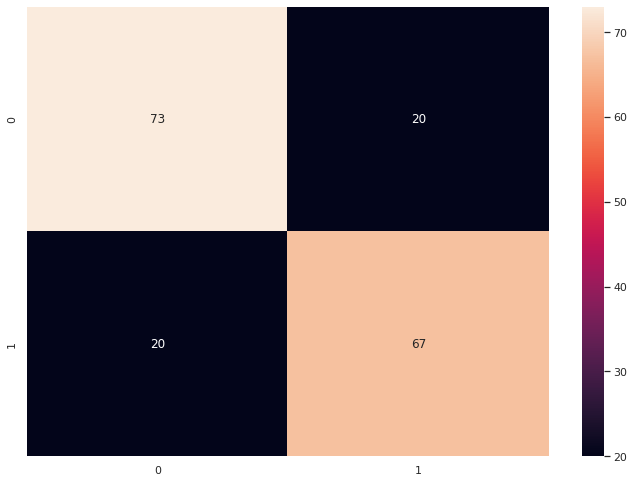

In [ ]:
#Plotting confusion matrix
cm = confusion_matrix(y_test, np.round(predictions_test))
f = sns.heatmap(cm, annot=True, fmt='d')

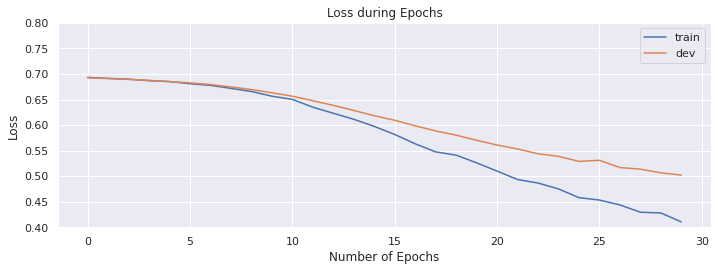

In [ ]:
import matplotlib.pyplot as pyplot
#Plot loss during training/Manually adjusted patience to stop at 4 epochs
pyplot.subplot(211)
plt.ylim((0.4,0.8))
plt.title('Loss during Epochs')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='dev')
pyplot.legend();

In [ ]:
#Classification Report on train,dev,test datasets.

print('Neural Network')
print('')
print('Train')
print(classification_report(y_train,np.round(model.predict(X_train_centroids))))
print('')
print('Dev')
print(classification_report(y_dev,np.round(model.predict(X_dev_centroids))))
print('')
print('Test')
print(classification_report(y_test,np.round(predictions_test)))

Neural Network

Train
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       350
           1       0.81      0.85      0.83       350

    accuracy                           0.82       700
   macro avg       0.83      0.82      0.82       700
weighted avg       0.83      0.82      0.82       700


Dev
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        62
           1       0.73      0.83      0.77        58

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120


Test
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        93
           1       0.77      0.77      0.77        87

    accuracy                           0.78       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.78      0.78      0.

In [ ]:

#Training AUC for the 2 Classes
p,r,t = precision_recall_curve(y_train,model.predict(X_train_centroids))
positive_area=auc(r,p)
print('Train Positive',positive_area)

p2,r2,t2 = precision_recall_curve(1-y_train,1-model.predict(X_train_centroids))
negative_area=auc(r2,p2)
print('Train Negative',negative_area)

#Dev AUC for the 2 Classes
p3,r3,t3 = precision_recall_curve(y_dev,model.predict(X_dev_centroids))
positive_area2=auc(r3,p3)
print('Dev Positive',positive_area2)

p4,r4,t4 = precision_recall_curve(1-y_dev,1-model.predict(X_dev_centroids))
negative_area2=auc(r4,p4)
print('Dev Negative',negative_area2)


#Test AUC for the 2 Classes
p5,r5,t5 = precision_recall_curve(y_test,model.predict(X_test_centroids))
positive_area3=auc(r5,p5)
print('Test Positive',positive_area3)

p6,r6,t6 = precision_recall_curve(1-y_test,1-model.predict(X_test_centroids))
negative_area3=auc(r6,p6)
print('Test Negative',negative_area3)

Train Positive 0.9059954871157168
Train Negative 0.9205073796783176
Dev Positive 0.8166098982782634
Dev Negative 0.8576591468679888
Test Positive 0.8096734514172064
Test Negative 0.82552294642149


##### RNN

In [ ]:
#Initializing early-stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8) 

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np
import os


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return 

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
import numpy as np


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
      return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
      return K.dot(x, kernel)


# class LinearAttention(Layer):
#     def __init__(self,
#                  kernel_regularizer=None, bias_regularizer=None,
#                  W_constraint=None, b_constraint=None,
#                  bias=True,
#                  return_attention=False,
#                  **kwargs):
        
#         self.supports_masking = True
#         self.init = initializers.get('glorot_uniform')

#         self.W_regularizer = regularizers.get(kernel_regularizer)
#         self.b_regularizer = regularizers.get(bias_regularizer)

#         self.W_constraint = constraints.get(W_constraint)
#         self.b_constraint = constraints.get(b_constraint)

#         self.bias = bias
#         self.return_attention = return_attention
#         super(LinearAttention, self).__init__(**kwargs)

#     def build(self, input_shape):
#         assert len(input_shape) == 3

#         self.W = self.add_weight(shape=(input_shape[-1],),
#                                  initializer=self.init,
#                                  name='{}_W'.format(self.name),
#                                  regularizer=self.W_regularizer,
#                                  constraint=self.W_constraint)
#         if self.bias:
#             self.b = self.add_weight(shape=(1,),
#                                      initializer='zero',
#                                      name='{}_b'.format(self.name),
#                                      regularizer=self.b_regularizer,
#                                      constraint=self.b_constraint)
#         else:
#             self.b = None

#         self.built = True

#     def compute_mask(self, inputs, mask=None):
#         # do not pass the mask to the next layers
#         if self.return_attention:
#             return [None, None]
#         return None

#     def call(self, x, mask=None):
        
#         # eij = Wx + b
#         eij = dot_product(x, self.W)

#         if self.bias:
#             eij += self.b

#         # Apply mask
#         if mask is not None:
#             eij *= K.cast(mask, K.floatx())

#         # a = softmax(eij)
#         a = K.expand_dims(K.softmax(eij, axis=-1))
#         weighted_input = x * a
#         result = K.sum(weighted_input, axis=1)

#         if self.return_attention:
#             return [result, a]
#         return result

#     def compute_output_shape(self, input_shape):
#         if self.return_attention:
#             return [(input_shape[0], input_shape[-1]),
#                     (input_shape[0], input_shape[1])]
#         else:
#             return input_shape[0], input_shape[-1]


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None,W2_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,three_layers=False,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.W2_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)
        self.b3_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.W2_constraint = constraints.get(W2_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        self.b2_constraint = constraints.get(b_constraint)
        self.b3_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        self.three_layers = three_layers
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.three_layers==True:
          self.W2 = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                  initializer=self.init,
                                  name='{}_W2'.format(self.name),
                                  regularizer=self.W2_regularizer,
                                  constraint=self.W2_constraint)          
        if self.bias:
            self.b1 = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight(shape=(1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
            if self.three_layers==True:
              self.b3 = self.add_weight(shape=(1,),
                                      initializer='zero',
                                      name='{}_b3'.format(self.name),
                                      regularizer=self.b3_regularizer,
                                      constraint=self.b3_constraint)              
        else:
            self.b1 = None
            self.b2 = None
            self.b3 = None

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1

        uit = K.tanh(uit)
        if self.three_layers==True:
          uit=dot_product(uit,self.W2)
          if self.bias:
            uit+=self.b3
          uit=K.tanh(uit)
        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)
        if self.bias:
            eij += self.b2

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
 #RNN Tuner example
def build_model_test(hp):


# create an empty  model


  with tf.device('/device:GPU:0'):


    inputs = Input((50,)) #

    # Define the Embedding Layer with fastext weights
    embeddings = Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)

    drop_emb = Dropout(hp.Float('Dropout Rate',min_value=0.2,max_value=0.3,step=0.1))(embeddings)

    # Define a (Biderectional) RNN with LSTM cells
    bilstm = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.33))(drop_emb)

    drop_encodings = Dropout(hp.Float('Dropout Rate',min_value=0.2,max_value=0.3,step=0.1))(bilstm)

    # Pass the encoding through an Attention Layer
    x, attn = DeepAttention(return_attention=True,three_layers=hp.Choice('Three_layers',[True,False]))(drop_encodings)
    # x, attn = LinearAttention(return_attention=True)(drop_encodings)
    # for i in range(1, hp.Int("num_layers", 1, 2)):

    #   x, attn = DeepAttention(return_attention=True)(x)


    # Apply Droupout to the encoding produced by the attension mechanism
    drop_x = Dropout(hp.Float('Dropout Rate',min_value=0.2,max_value=0.3,step=0.1))(x) #x

    # # Pass through a Dense Layer
    # hidden = Dense(units=DENSE, activation="relu")(drop_x)

    # # Apply Dropout to the output of the Dense Layer
    # drop_out = Dropout(0.33)(hidden) 

 # Last pass through a Dense Layer with softmax activation to produce a probability distribution
  out = Dense(units=1, activation="sigmoid")( drop_x)

  # Wrap model --> Remember Functional API
  model2 = Model(inputs=inputs, outputs=out)
  print(model2.summary())

  model2.compile(loss='binary_crossentropy',
                  optimizer=Adam(hp.Choice("learning_rate", values=[1e-3, 1e-4])),
                  metrics=["accuracy"])

  if not os.path.exists('/content/gdrive/My Drive/checkpoints'):
    os.makedirs('/content/gdrive/My Drive/checkpoints')

  checkpoint = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/BiLSTM_attn.hdf5',
                                monitor='val_accuracy', 
                                mode='max', verbose=2,
                                save_best_only=True,
                                save_weights_only=True)
  return model2 

In [ ]:
 tuner = kt.Hyperband(
    build_model_test,
    objective='val_accuracy') 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           150600    
                                                                 
 dropout_4 (Dropout)         (None, 50, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          320800    
 l)                                                              
                                                                 
 dropout_5 (Dropout)         (None, 50, 200)           0         
                                                                 
 deep_attention (DeepAttenti  [(None, 200),            80402     
 on)                          (None, 50, 1)]                 

In [ ]:
 tuner.search(
    x=train_data,
    y=y_train,
    epochs=3,
    batch_size= 64,
    validation_data=(dev_data,y_dev),
)
best_model = tuner.get_best_models(num_models=1)[0] 

Trial 8 Complete [00h 00m 28s]
val_accuracy: 0.6166666746139526

Best val_accuracy So Far: 0.625
Total elapsed time: 00h 04m 04s
INFO:tensorflow:Oracle triggered exit
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           150600    
                                                                 
 dropout (Dropout)           (None, 50, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          320800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 50, 200)           0         
                          

In [ ]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
h_model = tuner.hypermodel.build(best_hps)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 300)           150600    
                                                                 
 dropout_3 (Dropout)         (None, 50, 300)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 200)          320800    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 50, 200)           0         
                                                                 
 deep_attention_1 (DeepAtten  [(None, 200),            80402     
 tion)                        (None, 50, 1)]               

best_

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
Dropout Rate: 0.30000000000000004
Three_layers: 1
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.625
Trial summary
Hyperparameters:
Dropout Rate: 0.2
Three_layers: 0
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.625
Trial summary
Hyperparameters:
Dropout Rate: 0.30000000000000004
Three_layers: 1
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6166666746139526
Trial summary
Hyperparameters:
Dropout Rate: 0.2
Three_layers: 1
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6000000238418579
Trial summary
Hyperparameters:
Dropout Rate: 0.30000000000000004
Three_layers: 0
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.574999988

In [ ]:
history = best_model.fit(train_data, 
                    y_train,
                    validation_data=(dev_data, y_dev),
                    batch_size=64,
                    epochs=50,
                    shuffle=True,
                    callbacks=[Metrics(valid_data=(dev_data, y_dev))])

Epoch 1/50
11/11 [==============================] - 24s 1s/step - loss: 0.6908 - accuracy: 0.5629 - val_loss: 0.6899 - val_accuracy: 0.5583 - val_f1: 0.3520 - val_recall: 0.5167 - val_precision: 0.2669
Epoch 2/50
11/11 [==============================] - 10s 886ms/step - loss: 0.6893 - accuracy: 0.5357 - val_loss: 0.6890 - val_accuracy: 0.5500 - val_f1: 0.3520 - val_recall: 0.5167 - val_precision: 0.2669
Epoch 3/50
11/11 [==============================] - 10s 948ms/step - loss: 0.6878 - accuracy: 0.5614 - val_loss: 0.6880 - val_accuracy: 0.5583 - val_f1: 0.3520 - val_recall: 0.5167 - val_precision: 0.2669
Epoch 4/50
11/11 [==============================] - 10s 942ms/step - loss: 0.6869 - accuracy: 0.5543 - val_loss: 0.6869 - val_accuracy: 0.5583 - val_f1: 0.3520 - val_recall: 0.5167 - val_precision: 0.2669
Epoch 5/50
11/11 [==============================] - 9s 836ms/step - loss: 0.6844 - accuracy: 0.5529 - val_loss: 0.6856 - val_accuracy: 0.5667 - val_f1: 0.3520 - val_recall: 0.5167 - v

In [ ]:
#Classifying with our model
predictions_train = best_model.predict(train_data)
predictions_dev = best_model.predict(dev_data)
predictions_test = best_model.predict(test_data)

#Calculating F1 score
score = f1_score(y_test, np.round(predictions_test))

print("Test f1-score: {:.2f}% \n".format(score*100)) 

Test f1-score: 67.92% 



In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout, Bidirectional, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import Model

LSTM_SIZE = 30

with tf.device('/device:GPU:0'):

  inputs = Input((50,))
  
  # Define the Embedding Layer with fastext weights
  embeddings = Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], 
                         input_length=300, mask_zero=True, trainable=False)(inputs)
  drop_emb = Dropout(0.7)(embeddings)
  
  # Define a (Biderectional) RNN with LSTM cells
  bilstm = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True, recurrent_dropout=0.2))(drop_emb)
  drop_encodings = Dropout(0.2)(bilstm)

  # Pass the encoding through an Attention Layer
  x, attn = DeepAttention(return_attention=True,three_layers=False)(drop_encodings)
  # x, attn = LinearAttention(return_attention=True)(drop_encodings)

  # Apply Droupout to the encoding produced by the attension mechanism
  drop_x = Dropout(0.5)(x)

  # # Pass through a Dense Layer
  # hidden = Dense(units=DENSE, activation="relu")(drop_x)
  # # Apply Dropout to the output of the Dense Layer
  # drop_out = Dropout(0.33)(hidden)

  # Last pass through a Dense Layer with softmax activation to produce a probability distribution
  out = Dense(units=1, activation="sigmoid")(drop_x)
  
  # Wrap model --> Remember Functional API
  model2 = Model(inputs=inputs, outputs=out)
  print(model2.summary())

  model2.compile(loss='binary_crossentropy',
                 optimizer=Adam(lr=0.001),
                 metrics=["accuracy"])

  if not os.path.exists('/content/gdrive/My Drive/checkpoints'):
    os.makedirs('/content/gdrive/My Drive/checkpoints')

  checkpoint = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/BiLSTM_attn.hdf5',
                               monitor='val_accuracy', 
                               mode='max', verbose=2,
                               save_best_only=True,
                               save_weights_only=True) 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 300)           150600    
                                                                 
 dropout_6 (Dropout)         (None, 50, 300)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 60)           79440     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 50, 60)            0         
                                                                 
 deep_attention_2 (DeepAtten  [(None, 60),             3721      
 tion)                        (None, 50, 1)]               

In [ ]:
history = model2.fit(train_data, 
                    y_train,
                    validation_data=(dev_data, y_dev),
                    batch_size=64,
                    epochs=50,
                    shuffle=True,
                    callbacks=[Metrics(valid_data=(dev_data, y_dev)),
                    checkpoint])

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5086 — val_f1: 0.352015 — val_precision: 0.266944 — val_recall: 0.516667

Epoch 1: val_accuracy improved from -inf to 0.52500, saving model to /content/gdrive/My Drive/checkpoints/BiLSTM_attn.hdf5
11/11 [==============================] - 17s 1s/step - loss: 0.6928 - accuracy: 0.5086 - val_loss: 0.6889 - val_accuracy: 0.5250 - val_f1: 0.3520 - val_recall: 0.5167 - val_precision: 0.2669
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.5171 — val_f1: 0.352015 — val_precision: 0.266944 — val_recall: 0.516667

Epoch 2: val_accuracy improved from 0.52500 to 0.53333, saving model to /content/gdrive/My Drive/checkpoints/BiLSTM_attn.hdf5
11/11 [==============================] - 10s 895ms/step - loss: 0.6887 - accuracy: 0.5171 - val_loss: 0.6857 - val_accuracy: 0.5333 - val_f1: 0.3520 - val_recall: 0.5167 - val_precision: 0.2669
Epoch 3/50
11/11 [======================

In [ ]:
#Classifying with our model
predictions_train = model2.predict(train_data)
predictions_dev = model2.predict(dev_data)
predictions_test = model2.predict(test_data)

#Calculating F1 score
score = f1_score(y_test, np.round(predictions_test))

print("Test f1-score: {:.2f}% \n".format(score*100)) 

Test f1-score: 64.90% 



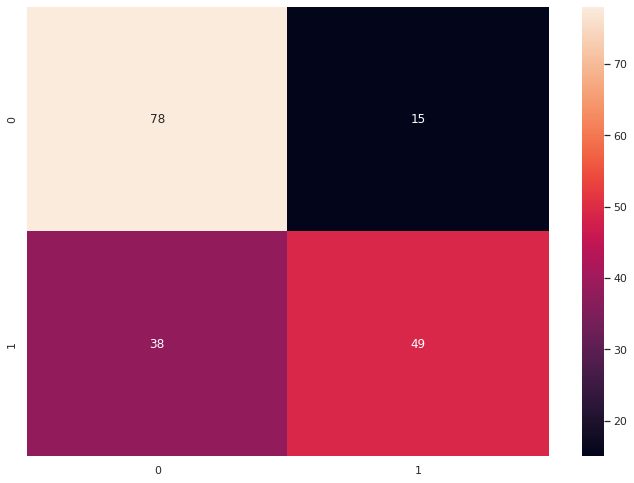

In [ ]:
#Plotting confusion matrix
cm = confusion_matrix(y_test, np.round(predictions_test))
f = sns.heatmap(cm, annot=True, fmt='d')

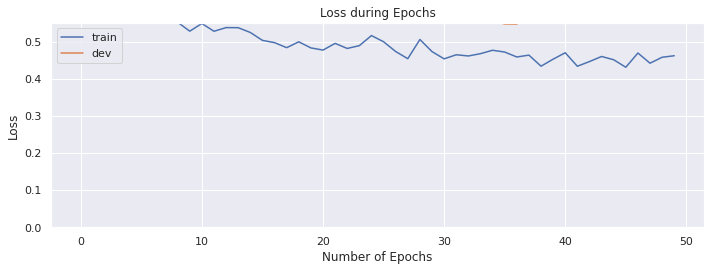

In [ ]:
import matplotlib.pyplot as pyplot
#Plot loss during training/Manually adjusted patience to stop at 4 epochs
pyplot.subplot(211)
plt.ylim((0,0.55))
plt.title('Loss during Epochs')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='dev')
pyplot.legend();

In [ ]:
#Classification Report on train,dev,test datasets.

print('RNN')
print('')
print('Train')
print(classification_report(y_train,np.round(predictions_train)))
print('')
print('Dev')
print(classification_report(y_dev,np.round(predictions_dev)))
print('')
print('Test')
print(classification_report(y_test,np.round(predictions_test)))

RNN

Train
              precision    recall  f1-score   support

           0       0.80      0.91      0.86       350
           1       0.90      0.78      0.83       350

    accuracy                           0.85       700
   macro avg       0.85      0.85      0.84       700
weighted avg       0.85      0.85      0.84       700


Dev
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        62
           1       0.72      0.62      0.67        58

    accuracy                           0.70       120
   macro avg       0.70      0.70      0.70       120
weighted avg       0.70      0.70      0.70       120


Test
              precision    recall  f1-score   support

           0       0.67      0.84      0.75        93
           1       0.77      0.56      0.65        87

    accuracy                           0.71       180
   macro avg       0.72      0.70      0.70       180
weighted avg       0.72      0.71      0.70       18

In [ ]:
#Training AUC for the 2 Classes
p,r,t = precision_recall_curve(y_train,np.round(predictions_train))
positive_area=auc(r,p)
print('Train Positive',positive_area)

p2,r2,t2 = precision_recall_curve(1-y_train,1-np.round(predictions_train))
negative_area=auc(r2,p2)
print('Train Negative',negative_area)

#Dev AUC for the 2 Classes
p3,r3,t3 = precision_recall_curve(y_dev,np.round(predictions_dev))
positive_area2=auc(r3,p3)
print('Dev Positive',positive_area2)

p4,r4,t4 = precision_recall_curve(1-y_dev,1-np.round(predictions_dev))
negative_area2=auc(r4,p4)
print('Dev Negative',negative_area2)


#Test AUC for the 2 Classes
p5,r5,t5 = precision_recall_curve(y_test,np.round(predictions_test))
positive_area3=auc(r5,p5)
print('Test Positive',positive_area3)

p6,r6,t6 = precision_recall_curve(1-y_test,1-np.round(predictions_test))
negative_area3=auc(r6,p6)
print('Test Negative',negative_area3)

Train Positive 0.8946168401135289
Train Negative 0.8805814788226848
Dev Positive 0.7620114942528736
Dev Negative 0.7882872503840246
Test Positive 0.7699772509578544
Test Negative 0.7972284019280682
